# INET 4710 Final Project

**For this project, we will be analyzing the NPR Media Dialog Transcripts. The analysis will focus on Natural Language Processing, in tandem with clustering algorithms.**

# Setup

To get started, we need to upload two CSV files: "episode.csv" and "utterances.csv"

After that, we need to install PySpark.

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 198 kB 54.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=1b175e2f69b1abc6a588c21c179f70f8e0877bc637bcfa10c1f0e6252b0c9680
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# Exploratory Data Analysis

For the Exploratory Data Analysis, we will be using Pandas.

In [2]:
import numpy as np
import pandas as pd

utterance_path = "utterances.csv"

In [3]:
utterance_df = pd.read_csv(utterance_path)
utterance_df.head(2)

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...


**How long is the typical interview?**

If we were to define length as the number of 'episode orders' per episode, then we can simply count how many times each episode occurs in the 'utterances.csv'

In [4]:
utterance_df.groupby("episode").count()

,episode_order,speaker,utterance
episode,,,
1,11,11,11
2,16,16,16
3,15,15,15
4,28,28,28
5,51,51,51
...,...,...,...
140746,28,28,28
140747,16,16,16
140748,19,19,19


In [5]:
utterance_df.groupby("episode").count()["utterance"].mean()

30.492718261532595

We find that the average episode length is about 30 episode orders.

**What is the distribution of the total number of words?**

Now we will be analyzing how many words each interview contains. We will also look at the average episode length in terms of word count, as well as the standard deviation and the overall distribution.

In [6]:
utterance_df = utterance_df.dropna()
utterance_df['wordCount'] = [len(x.split()) for x in utterance_df['utterance'].tolist()]
utterance_df.head(10)

,episode,episode_order,speaker,utterance,wordCount
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",50
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,87
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",33
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,118
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",10
5,57264,14,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's exactly right.,3
6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...,53
7,57264,16,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. There's a lot of deal making tha...,83
8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in...",50
9,57264,18,JOHN (Caller),Hello.,1


In [7]:
utterance_df.groupby("episode")["wordCount"].sum()

episode
1          673
2          659
3          564
4          902
5         1598
          ... 
140746     729
140747     497
140748     675
140749    1178
141179     425
Name: wordCount, Length: 104920, dtype: int64

A histogram is good for visualizing the overall distribution.

In [8]:
!pip install pyspark-dist-explore

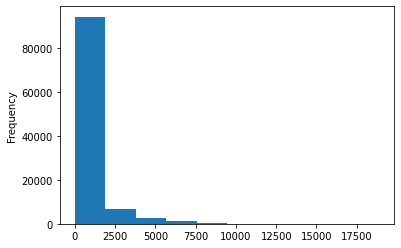

In [9]:
utterance_df.groupby("episode")["wordCount"].sum().plot.hist()

The histogram shows that the distribution is skewed left, with the vast majority of interviews having less than 5000 words.

In [10]:
utterance_df.groupby("episode")["wordCount"].sum().mean()

1036.4942051086541

In [11]:
utterance_df.groupby("episode")["wordCount"].sum().std()

1108.9935345163572

Here, we find that the mean is about 1036.49 and the standard deviation is about 1108.99. This means that an average interview has about 1039 words. Note that the standard deviation is larger than the mean, and it seems that the outliers, or unusually long interviews, inflated the standard deviation.

**What is the distribution of the total number of distinct words?**

This is trickier as we have to make sure each word is 'distinct.' For example, the words 'Book' and 'book' should be considered as the same word. This would require some sort of text data pre-processing, such as getting rid of punctuations and capitalization.

We will get rid of capitalization and punctuations. To do that, we need lower() and translate().

In [12]:
import string

processed_df = utterance_df
processed_df["cleanUtterance"] = processed_df['utterance'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [13]:
processed_df.head(10)

,episode,episode_order,speaker,utterance,wordCount,cleanUtterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",50,its a 2200mile race to give some sense of pers...
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,87,so for a top competitor like lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",33,so in every team presumably theres one star on...
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,118,thats right each team has nine riders and what...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",10,so slipstream this is like drafting in car rac...
5,57264,14,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's exactly right.,3,thats exactly right
6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...,53,and so the guy whos in back has an easier time...
7,57264,16,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. There's a lot of deal making tha...,83,thats right theres a lot of deal making that c...
8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in...",50,were talking with loren mooney the editorinchi...
9,57264,18,JOHN (Caller),Hello.,1,hello


It is a good practice to drop rows with null values.

In [14]:
processed_df = processed_df.dropna()
processed_df.count()

episode           3199296
episode_order     3199296
speaker           3199296
utterance         3199296
wordCount         3199296
cleanUtterance    3199296
dtype: int64

We then count distinct words using list comprehension.

In [15]:
processed_df['distinctWordCount'] = [len(set(x.split())) for x in utterance_df['cleanUtterance'].tolist()]

In [16]:
processed_df.head(10)

,episode,episode_order,speaker,utterance,wordCount,cleanUtterance,distinctWordCount
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",50,its a 2200mile race to give some sense of pers...,40
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,87,so for a top competitor like lance to try to m...,68
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",33,so in every team presumably theres one star on...,26
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,118,thats right each team has nine riders and what...,82
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",10,so slipstream this is like drafting in car rac...,10
5,57264,14,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's exactly right.,3,thats exactly right,3
6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...,53,and so the guy whos in back has an easier time...,42
7,57264,16,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. There's a lot of deal making tha...,83,thats right theres a lot of deal making that c...,64
8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in...",50,were talking with loren mooney the editorinchi...,43
9,57264,18,JOHN (Caller),Hello.,1,hello,1


In [17]:
processed_df.groupby("episode")["distinctWordCount"].sum()

episode
1          464
2          497
3          452
4          769
5         1291
          ... 
140746     579
140747     428
140748     531
140749     848
141179     341
Name: distinctWordCount, Length: 104920, dtype: int64

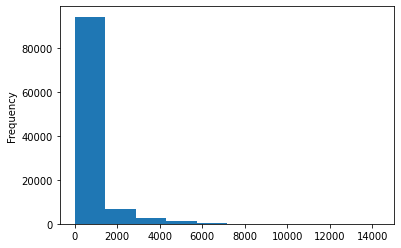

In [18]:
processed_df.groupby("episode")["distinctWordCount"].sum().plot.hist()

This histogram is very similar to the previous histogram. The distribution is skewed heavily to the left. A major difference is that the length is shorter, as the vast majority of interviews have less than 4000 distinct words. This is not surprising because sentences usually have duplicate words.

In [19]:
processed_df.groupby("episode")["distinctWordCount"].sum().mean()

813.589830346931

In [20]:
processed_df.groupby("episode")["distinctWordCount"].sum().std()

830.2850341994177

The mean is about 813.59 and the standard deviation is about 830.29. This is very similar to what we had with the number of total words. Again, the standard deviation is higher than the mean, with the same reason of some interviews being much longer than others.

**Word Frequency**

We will be looking at the top most common words of the entire dataset.

Before doing that, however, we need to get rid of 'stop words,' which are very common words that provide little to no useful information. Examples of stop words include articles (a, an, the) and pronouns (he, she, it etc).

In [21]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [22]:
from collections import Counter

freq_count = Counter()

processed_df = processed_df.dropna()
processed_df["cleanUtterance"].str.split().apply(freq_count.update)

freq_count.most_common(20)

[('the', 5366933),
 ('and', 3106745),
 ('to', 3005070),
 ('of', 2869857),
 ('a', 2529448),
 ('that', 2043228),
 ('in', 2004068),
 ('you', 1458386),
 ('is', 1406496),
 ('i', 1309669),
 ('it', 1038763),
 ('for', 946321),
 ('this', 869945),
 ('on', 765412),
 ('was', 761460),
 ('have', 699711),
 ('we', 694138),
 ('are', 672728),
 ('with', 659168),
 ('but', 643268)]

As expected, the most common words are stop words. We will have to delete them from our word frequency counter.

In [23]:
for word in stop:
    if word in freq_count:
        del freq_count[word]

freq_count.most_common(20)

[('know', 510226),
 ('people', 412006),
 ('think', 376951),
 ('one', 339107),
 ('us', 335134),
 ('well', 334941),
 ('like', 325144),
 ('thats', 303684),
 ('going', 288293),
 ('would', 253250),
 ('im', 240437),
 ('get', 229559),
 ('really', 219825),
 ('dont', 203981),
 ('right', 200722),
 ('new', 194728),
 ('says', 194312),
 ('time', 194162),
 ('much', 193281),
 ('say', 189459)]

We observe that the top three most common words are 'know,' 'people,' and 'think.' This makes sense, considering that we hear these words a lot in our daily lives, but also not very useful because we use these words in many contexts. In other words, these words don't tell us which topics or current events were popular.

We will delete the word frequency counter now to free up some RAM memory.

In [24]:
del freq_count

**TF-IDF**

Even after deleting stop words, we found that the most common words were still not very informative. In this case, we can use the TF-IDF algorithm to extract more meaningful, but still very frequent, words.

The TF part, which stands for Term Frequency, is similar to what we did in the previous section - it simply counts each term's frequency.

The IDF part, however, is what makes this algorithm more effective. The problem with common words is that they can be used in many contexts, and as a result, they are not very informative. The IDF part, which stands for Inverse Document Frequency, remedies this problem by making sure that words that appear in many documents, or contexts, are not counted. In other words, the algorithm only counts words that are frequent in only certain contexts. This is effective because the most frequent words now have more specific meaning, and they can actually give us important hints on which topics were popular.

The problem is that this algorithm can be computationally expensive, and for this project, it does not seem feasible to apply this algorithm over the entire dataset. Therefore, we will be applying TF-IDF over a select few interviews.

Before going any further, let us examine "episodes.csv"

In [25]:
episode_path = "episodes.csv"

episode_df = pd.read_csv(episode_path)
episode_df.head()

,id,program,title,episode_date
0,98814,Morning Edition,Senate Ushers In New Year With 'Fiscal Cliff' ...,2013-01-01
1,98824,Morning Edition,Cheap Bubbly Or Expensive Sparkling Wine? Look...,2012-12-31
2,98821,Morning Edition,U.S. Gas Prices Reach Record Level In 2012,2013-01-01
3,98806,Morning Edition,House Approves 'Fiscal Cliff' Measure,2013-01-02
4,98823,Morning Edition,The Fiscal Cliff: A Love Story,2012-12-31


In [26]:
episode_df["program"].unique()

array(['Morning Edition', 'All Things Considered',
       'Weekend Edition Saturday', 'Talk of the Nation', 'News & Notes',
       'Day to Day', 'Weekend Edition Sunday'], dtype=object)

The program 'Talk of the Nation' sounds interesting. We will examine interviews in that program.

In [27]:
id_series = episode_df[episode_df["program"] == 'Talk of the Nation']["id"].tolist()

In [28]:
nation_df = processed_df[processed_df["episode"].isin(id_series)]

nation_df.head()

,episode,episode_order,speaker,utterance,wordCount,cleanUtterance,distinctWordCount
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ...",50,its a 2200mile race to give some sense of pers...,40
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...,87,so for a top competitor like lance to try to m...,68
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,...",33,so in every team presumably theres one star on...,26
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...,118,thats right each team has nine riders and what...,82
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra...",10,so slipstream this is like drafting in car rac...,10


For each episode, we will combine the corresponding "cleanUtterance" values into a single text.

In [29]:
nation_df = nation_df.groupby("episode")["cleanUtterance"].apply(','.join).reset_index()
nation_df

,episode,cleanUtterance
0,619,yes theres a group called architects and engin...
1,620,looking ahead to our last day many of our frie...
2,621,"laughter,nobody,because of the things we are w..."
3,622,and so its time to say goodbye as you probably...
4,623,"ding ding ding,that is the correct answer,i sa..."
...,...,...
9047,84432,this is talk of the nation im neal conan in w...
9048,84433,well the criminal division of the justice depa...
9049,84434,and from those satellite images what did this ...
9050,84651,but you have had a situation where liberals in...


Scikit-learn has a TfidfVectorizer library. We will use it to extract the top 100 words.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
x = tfidf_vec.fit_transform(nation_df['cleanUtterance'])

In [31]:
indices = np.argsort(tfidf_vec.idf_)[::-1]
features = tfidf_vec.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['émigrés', 'interrogationrelated', 'intervenein', 'intervener', 'interventionbased', 'interventionis', 'interviewedand', 'interviewedim', 'interviewhaving', 'interviewingin', 'interviewpardon', 'interwarph', 'interweaving', 'interwebs', 'intewhat', 'inthan', 'inthearmy', 'inthelightofday', 'inthemoment', 'inthen', 'inthewomb', 'inthey', 'inthrough', 'intifadas', 'intille', 'intimation', 'intime', 'intervarsity', 'intervalometer', 'intervaleph', 'interspeech', 'interrogationtraditional', 'interrogative', 'interrogatory', 'interrorem', 'interrupi', 'interruptible', 'interry', 'intershia', 'intersocial', 'interspaces', 'interspeciation', 'intersplices', 'interus', 'intersquad', 'interstatehighway', 'intersubject', 'interthe', 'intertheater', 'intertidal', 'intertie', 'intertropical', 'intertwines', 'interuniversity', 'interuptum', 'intimity', 'intisarph', 'intoalmost', 'intransigently', 'intraday', 'intraeuropean', 'intragroup', 'intrail', 'intralytix', 'intramarital', 'intramiddle', 'in

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The words are now more specific, as we see words that we don't typically use in our everyday lives. We can even guess the topic of some interviews. Even though TF-IDF is inadequate if we wanted to do a more comprehensive data analysis, this is still a good starting point that we can build upon.

**Summary**

This concludes the Exploratory Data Analysis. First, we observed that a typical interview contains about 1,000 words, or 800 distinct words. Second, we looked at the most common words and found that they were not very informative, even after eliminating the stop words. Lastly, we used the TF-IDF algorithm on a select few interviews and extracted words that were more useful.

# Experimentation

Now that we have a better understanding of our dataset, we can use Machine Learning algorithms to analyze the data in depth. For this project, we will use the LDA algorithm. We will experiment by trying out different hyperparameters, subsets, and prepreprocessing techniques. 

The focus of this project is topic modeling. We will be using LDA to achieve this goal. More precisely, we want to find clusters using LDA, and these clusters will help us group interviews into different categories.

**LDA Using TF-IDF**

There have been debates on the effectiveness of using TF-IDF with LDA. Some researchers have argued that using them together was detrimental to the performance of the algorithm, whereas others argued that it could actually be effective.

For this project, we will be using the TF-IDF matrix that we have obtained above and see which side the results favor. (Of course, this is just one experiment - one data point, so it will not prove or refute anything. It is simply an observation of how theories may work in real life.)

In [32]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=0)

lda.fit(x)

LatentDirichletAllocation(n_components=5, random_state=0)

In [33]:
tf_feature_names = tfidf_vec.get_feature_names_out()

In [34]:
# From Scikit-Learn documentation
# URL: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

# Plots the top N words from the model (in this case LDA)

import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

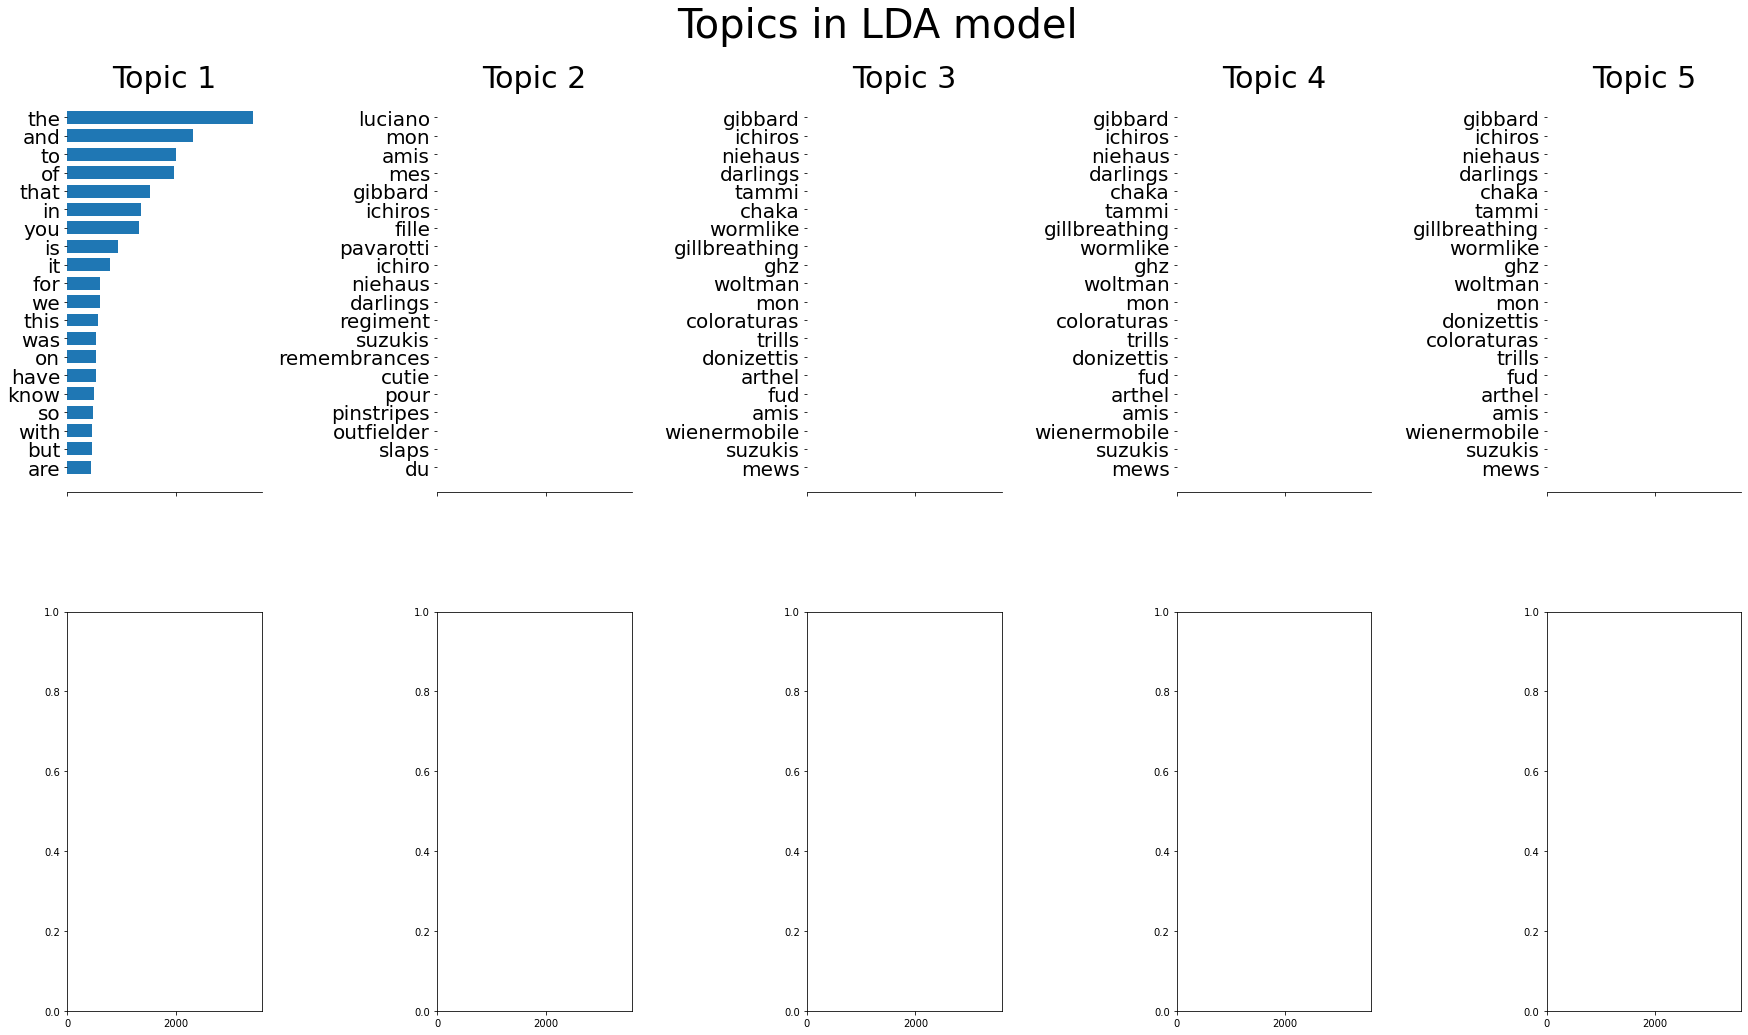

In [35]:
plot_top_words(lda, tf_feature_names, 20, "Topics in LDA model")

The first run is disappointing, as we see that stop words dominate Topic 1, and the frequency of more contextual words just pales in comparison. However, this does not prove anything yet. We should remove stop words and see how things improve.

TfidfVectorizer() provides a parameter called 'stop_words,' which we can use to filter out stop words.

In [36]:
tfidf_vec2 = TfidfVectorizer(stop_words = stop)
tfidf2 = tfidf_vec2.fit_transform(nation_df['cleanUtterance'])

In [37]:
lda.fit(tfidf2)

LatentDirichletAllocation(n_components=5, random_state=0)

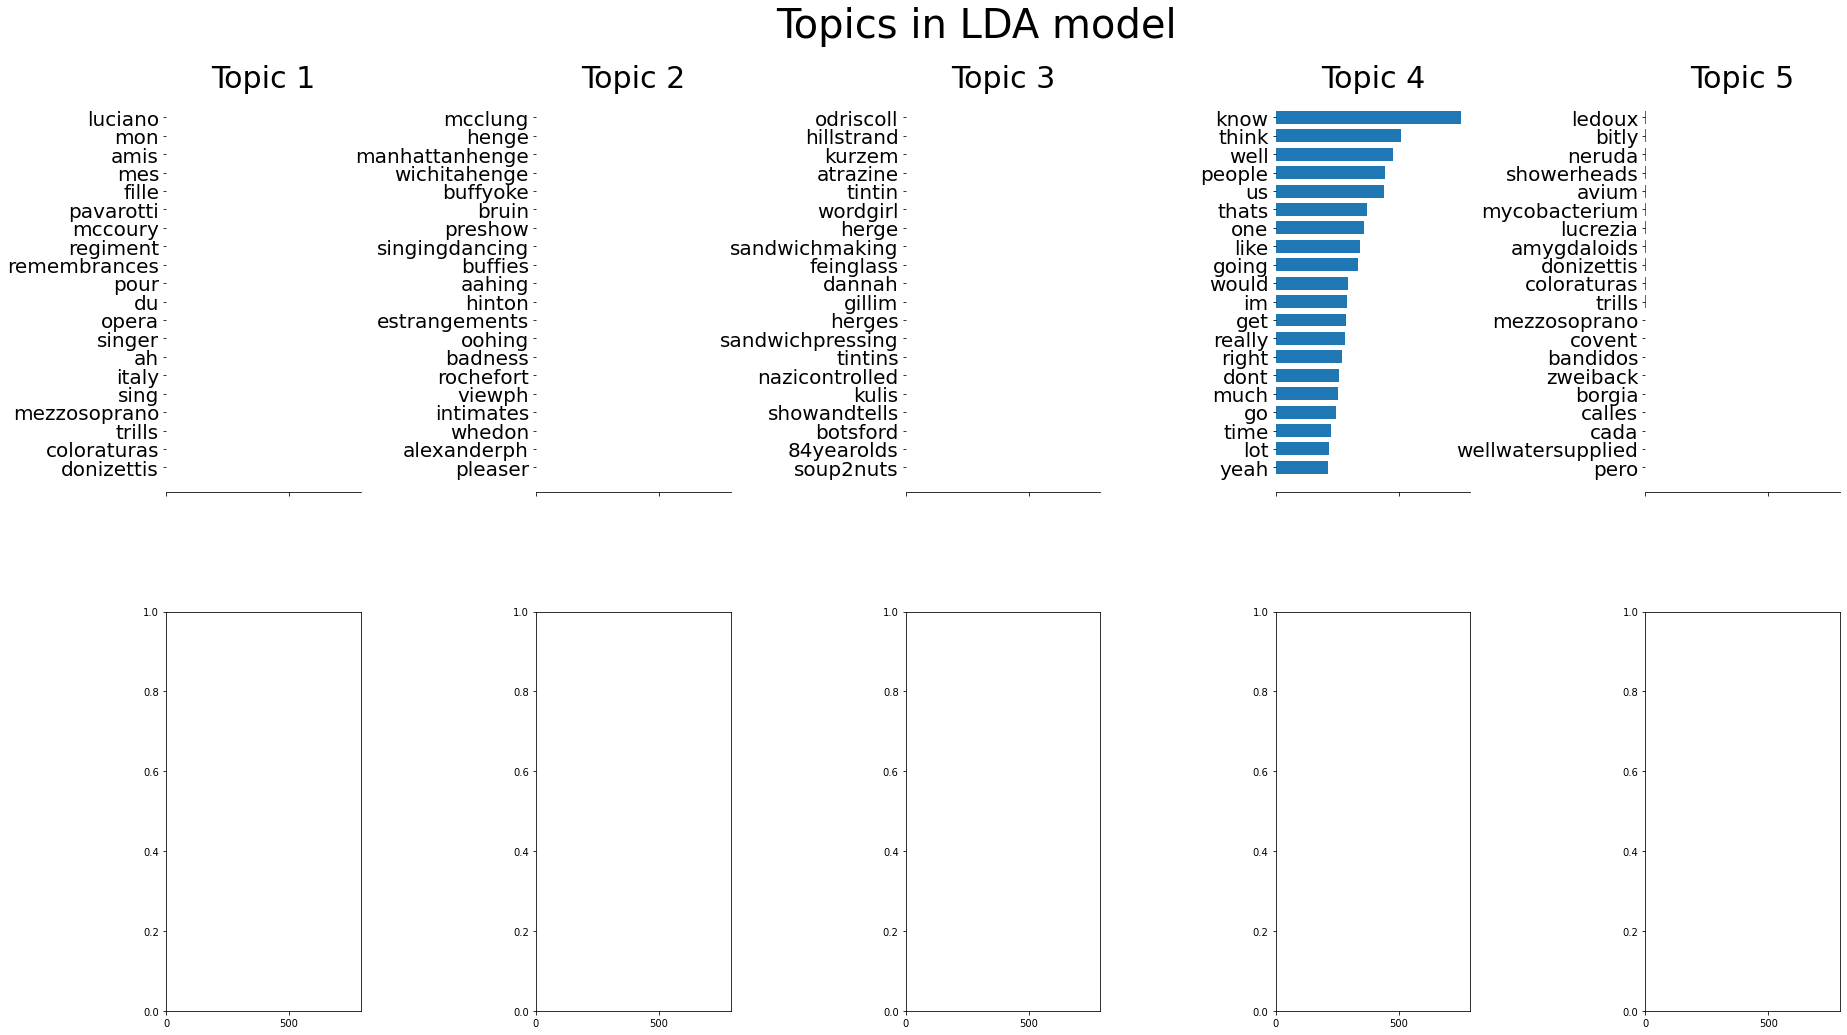

In [38]:
tf_feature_names = tfidf_vec2.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 20, "Topics in LDA model")

This is better than the last one, but still not great. What we observe are the words that are technically not stop words, but still used widely enough to offer little to no context. Take a look at Topic 4 - it is dominated by words like 'know,' 'think,' and 'well,' which are frequently used everyday, but provide no specific context. This is not useful when we want to do topic modeling; we want specific words used in specific contexts.

LatentDirichletAllocation() has many parameters. We can try changing some of these parameters to improve the performance.

We will increase n_components from 10, which is the default value, to 20.
Here, n_components denotes the number of topics, or clusters.

We can also try changing the learning method to "online," as opposed to the default "batch."
The parameter random_state will also be increased to 100.

One thing to note is that this may improve the performance, but it may also take longer to complete.

In [39]:
lda_model = LatentDirichletAllocation(n_components=20, max_iter=10,learning_method="online",random_state=100)

In [40]:
lda_output = lda_model.fit_transform(tfidf2)

IndexError: ignored

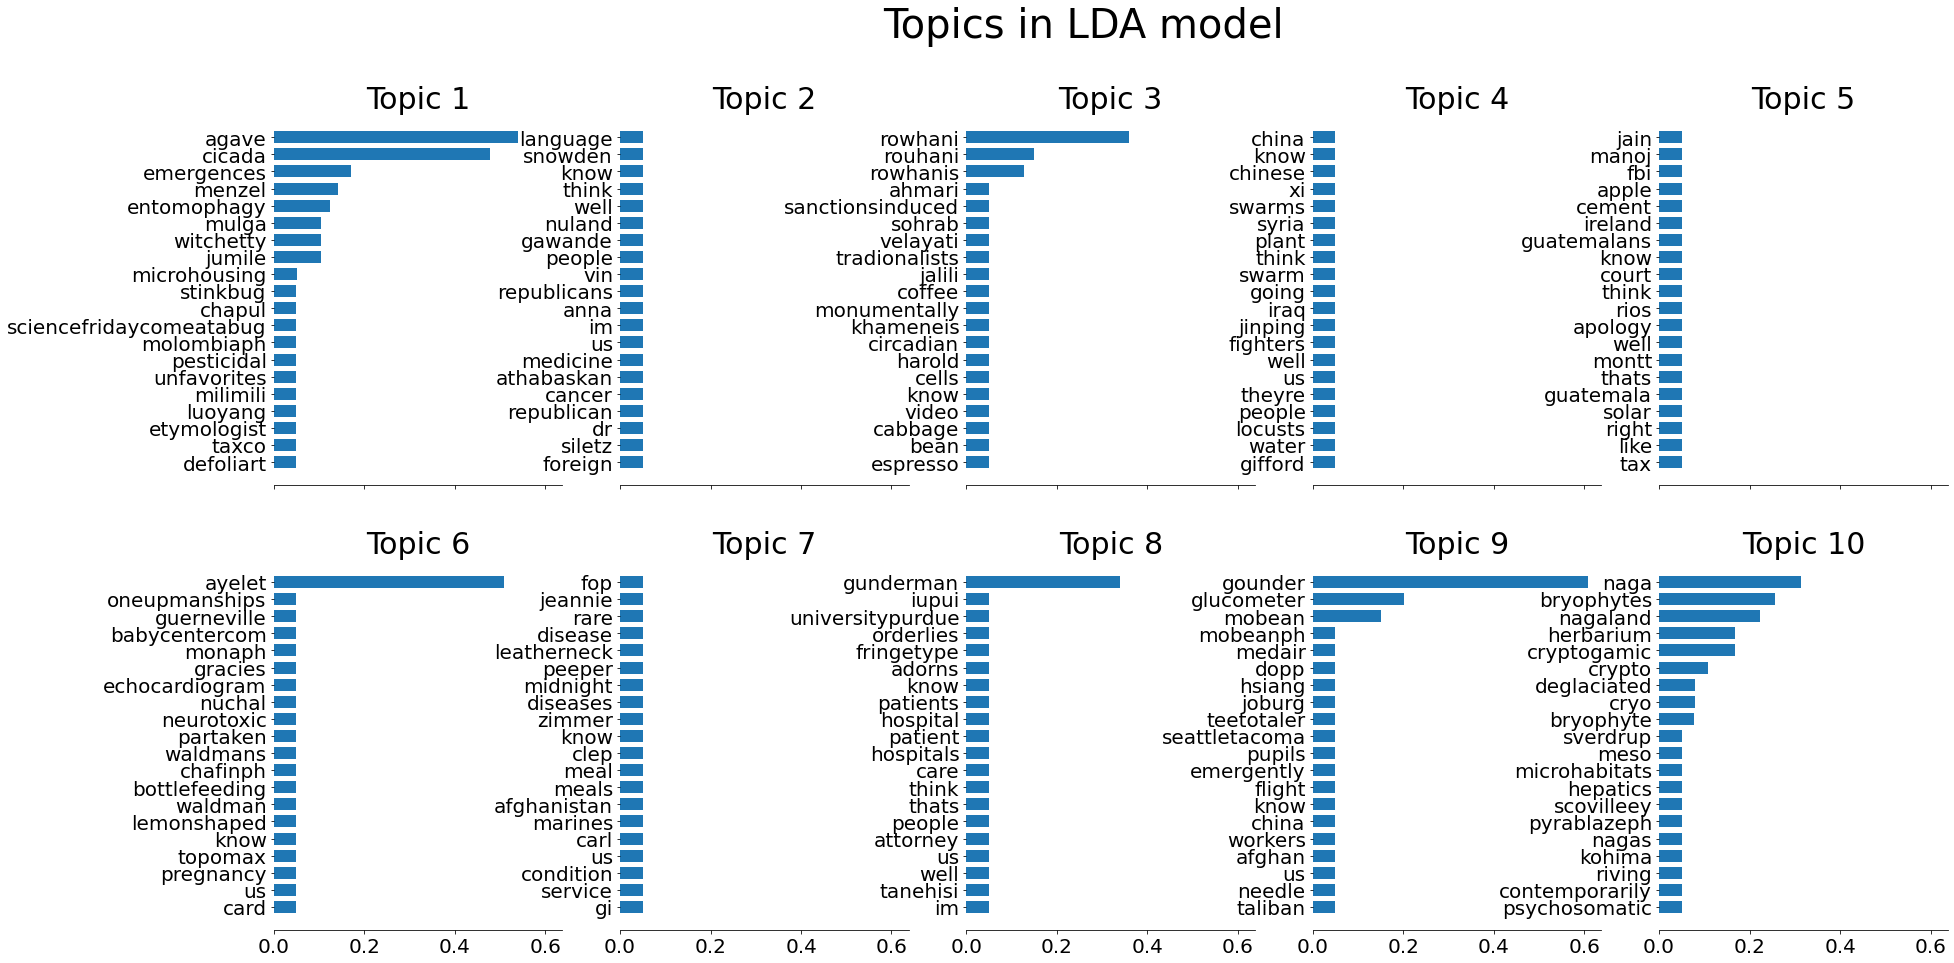

In [41]:
tf_feature_names = tfidf_vec2.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 20, "Topics in LDA model")

The improvement is clear. Each topic contains words that are used in certain contexts. For example, in Topic 3, we see words like "rouhani," "khameneis," "ahmari," and "sohrab," which are all words related to the Middle East. What can be improved upon is that some clusters seem to contain multiple topics. The same Topic 3 also contains words related to coffee, a topic which one could attempt to draw connections to the Middle East, but is generally considered unrelated.

So far, it seems that TF-IDF could in fact be used with LDA, as long as we have the right parameters.

What if we increase n_components to 30?

In [42]:
lda_model2 = LatentDirichletAllocation(n_components=30, max_iter=10,learning_method="online",random_state=100)

In [43]:
lda_output2 = lda_model2.fit_transform(tfidf2)

IndexError: ignored

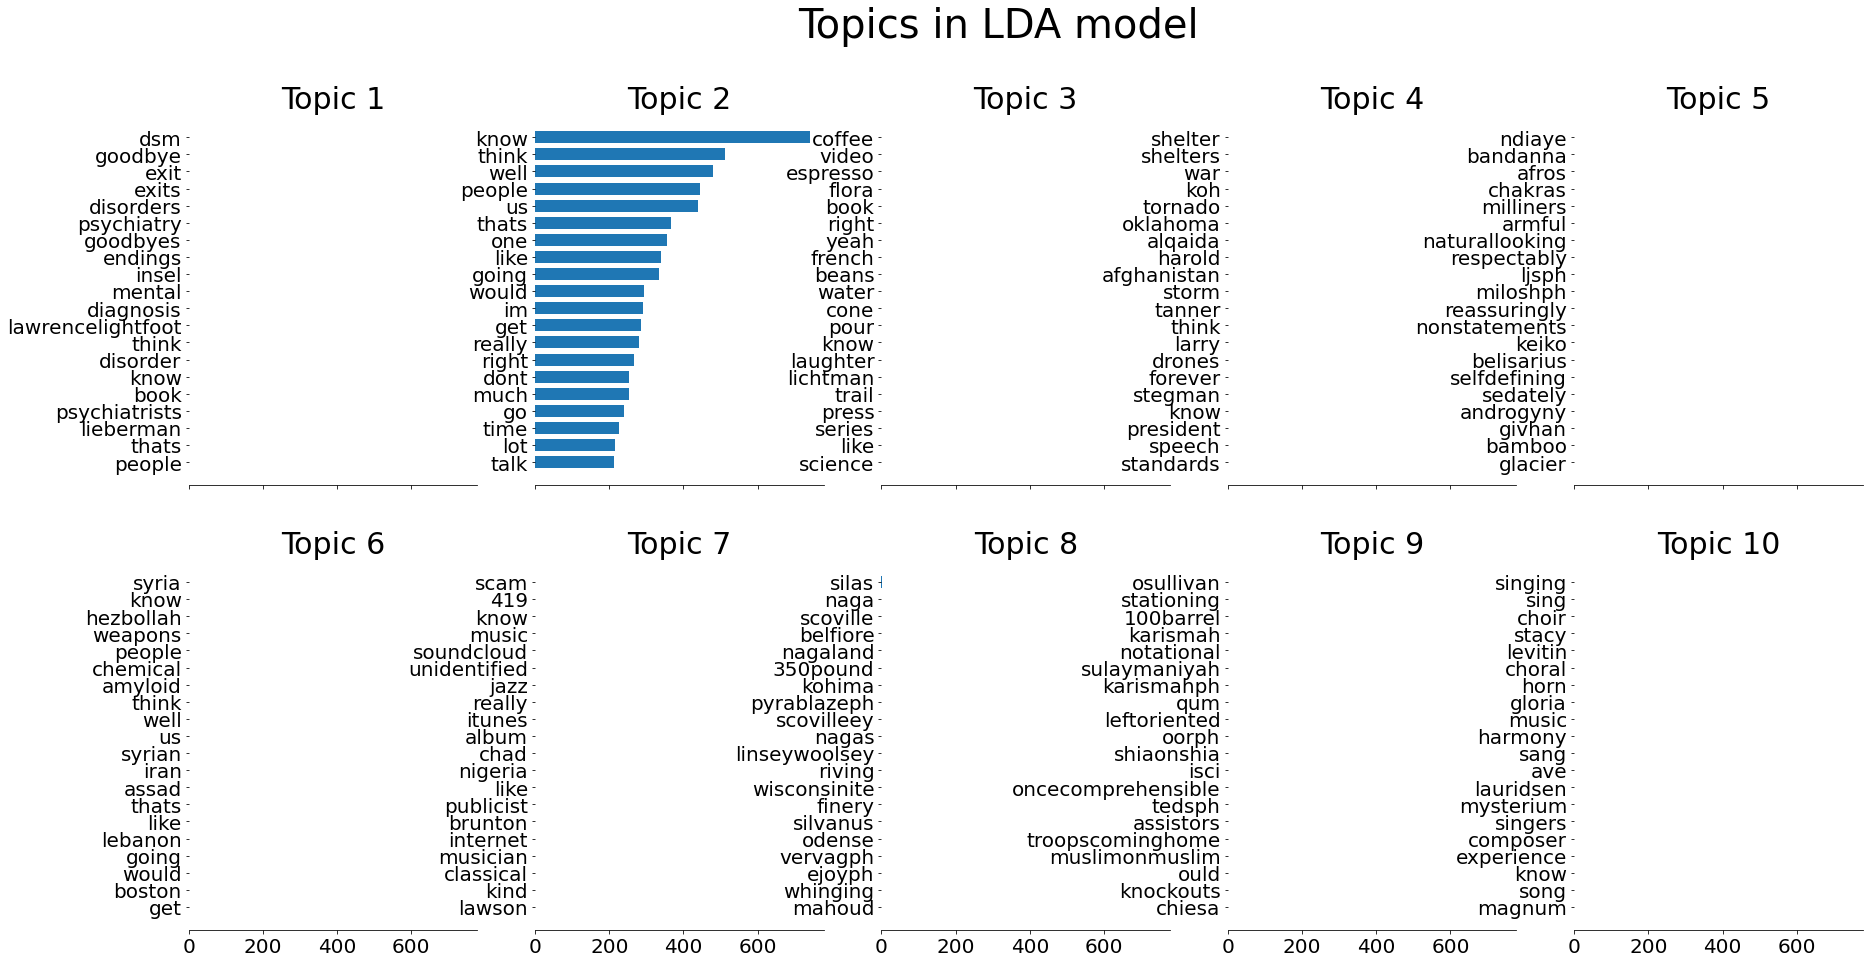

In [44]:
tf_feature_names = tfidf_vec2.get_feature_names_out()
plot_top_words(lda_model2, tf_feature_names, 20, "Topics in LDA model")

It seems clear that increasing the number of clusters does not always improve performance. We observe the return of words like 'know' and 'think.'

**Lemmatization**

Stemming and lemmatization are two popular text pre-processing techniques. In our  case, lemmatization seems more reasonable than Stemming, because of the risk of overstemming, where words with similar spellings but also with different meanings are reduced into the same words.

We first add a Lemmatizer from the NLTK library.

In [45]:
# From the Scikit-leearn documentation
# Link: https://scikit-learn.org/stable/modules/feature_extraction.html

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [47]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [49]:
tokenizer=LemmaTokenizer()

tfidf_vec3 = TfidfVectorizer(stop_words = stop, tokenizer=tokenizer)
tfidf3 = tfidf_vec3.fit_transform(nation_df['cleanUtterance'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  % sorted(inconsistent)


We will then use our best version of LDA.

In [50]:
lda_output = lda_model.fit_transform(tfidf3)

IndexError: ignored

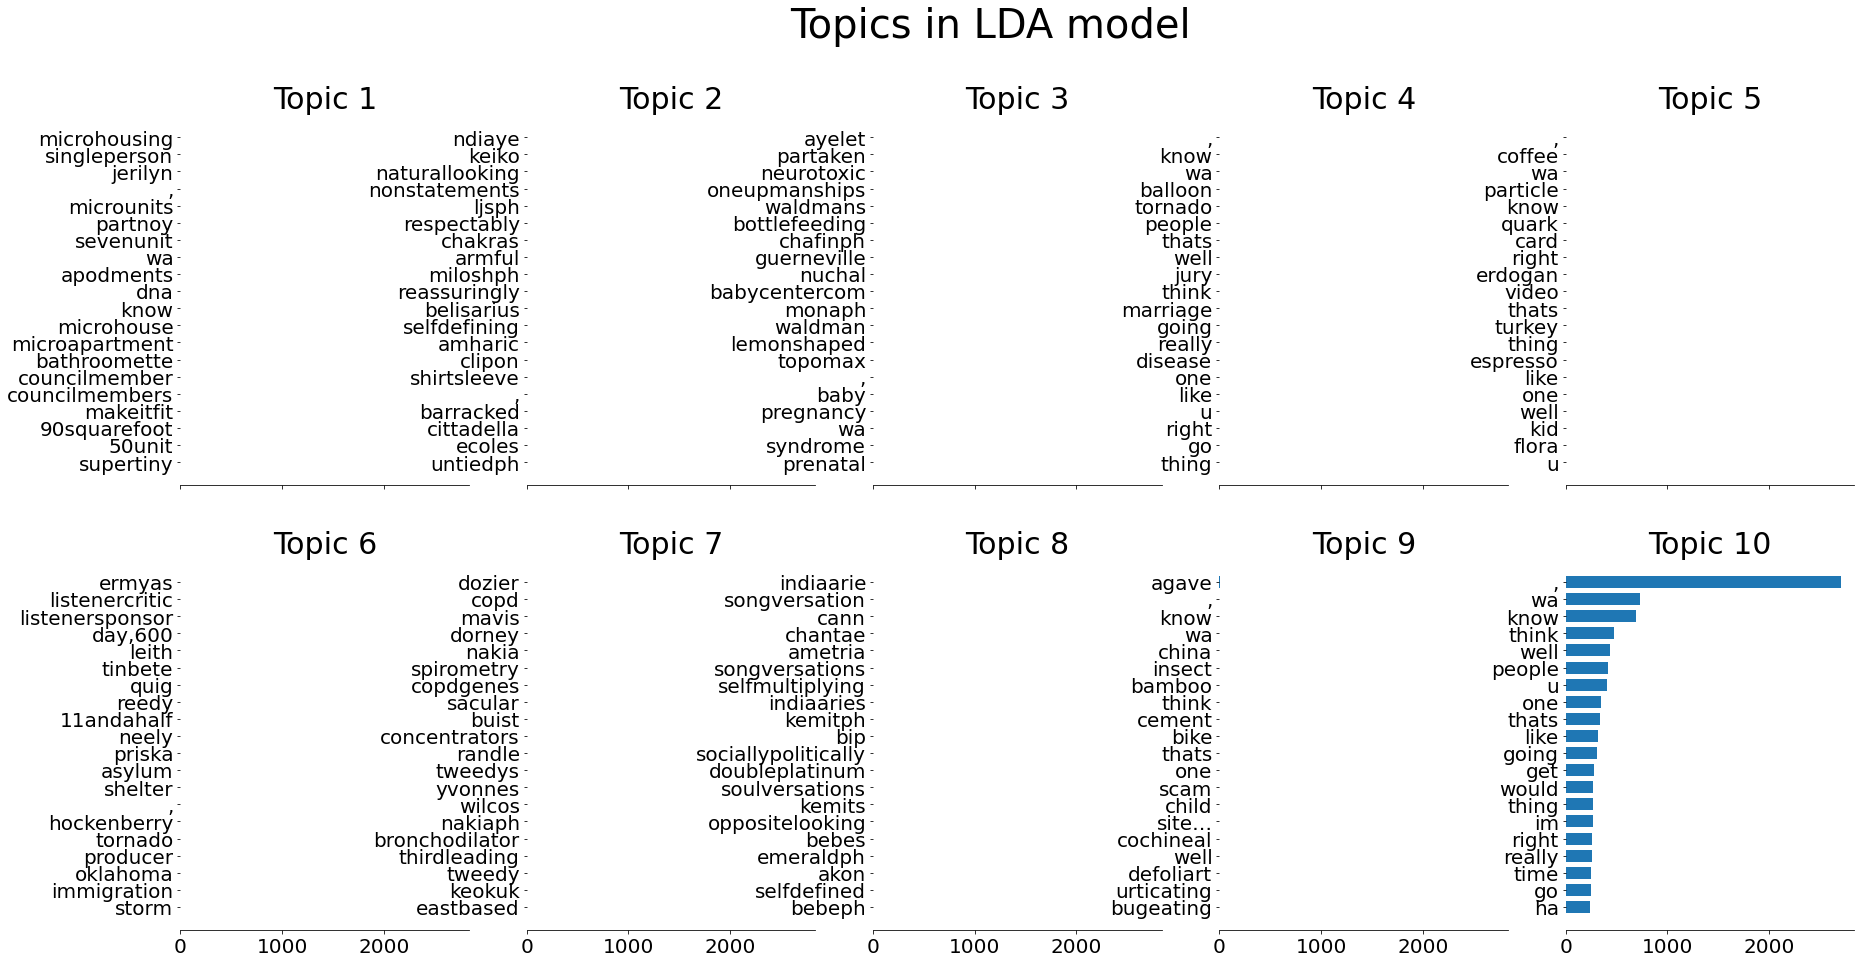

In [51]:
tf_feature_names = tfidf_vec3.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 20, "Topics in LDA model")

There is little to no improvement. In fact, it seems that using lemmatization resulted in poorer performance. For example, note the commas in several topics. Also note the return of words like 'know' and 'think.'

**Trying Out Another Program: Weekend Edition Sunday**

So far, we have one model that seems to be working, at least for the program "Talk of the Nation." How would our best model perform with other programs? In this section, we try another program called "Weekend Edition Sunday" and see how it goes.

In [66]:
id_series = episode_df[episode_df["program"] == 'Weekend Edition Sunday']["id"].tolist()
len(id_series)

5971

In [67]:
sunday_df = processed_df[processed_df["episode"].isin(id_series)]

sunday_df.head()

,episode,episode_order,speaker,utterance,wordCount,cleanUtterance,distinctWordCount
88,75004,1,"LIANE HANSEN, host",The Atlantic hurricane season officially ends ...,43,the atlantic hurricane season officially ends ...,35
89,75004,2,JON HAMILTON,Eight hurricanes formed in the North Atlantic ...,40,eight hurricanes formed in the north atlantic ...,35
90,75004,3,Mr. ALEXIS FERNANDEZ (History Teacher),(Through Translator) The waves were as high as...,53,through translator the waves were as high as t...,37
91,75004,4,JON HAMILTON,Fernandez teaches history at the University in...,80,fernandez teaches history at the university in...,65
92,75004,5,Mr. ALEXIS FERNANDEZ (History Teacher),"(Through Translator) In the '60s, we suffered ...",63,through translator in the 60s we suffered a lo...,48


In [68]:
sunday_df = sunday_df.groupby("episode")["cleanUtterance"].apply(','.join).reset_index()
sunday_df

,episode,cleanUtterance
0,1,the impeachment inquiry picks up tomorrow wher...
1,2,president trump has announced another new immi...
2,3,now to hong kong where antigovernment protests...
3,4,after hurricane dorian hit the bahamas last mo...
4,5,i agree a hundred percent the climate is chang...
...,...,...
5904,84078,basketball was invented in 1891 by dr james na...
5905,84079,this past week british voters returned tony bl...
5906,84080,manetedouard manet is right how about egads e...
5907,84081,from npr news this is weekend edition im lian...


In [69]:
tfidf_vec_sunday = TfidfVectorizer(stop_words = stop)
tfidf_sunday = tfidf_vec_sunday.fit_transform(sunday_df['cleanUtterance'])

In [70]:
lda_model_sunday = LatentDirichletAllocation(n_components=20, max_iter=10,learning_method="online",random_state=100)

In [71]:
lda_output_sunday = lda_model_sunday.fit_transform(tfidf_sunday)

IndexError: ignored

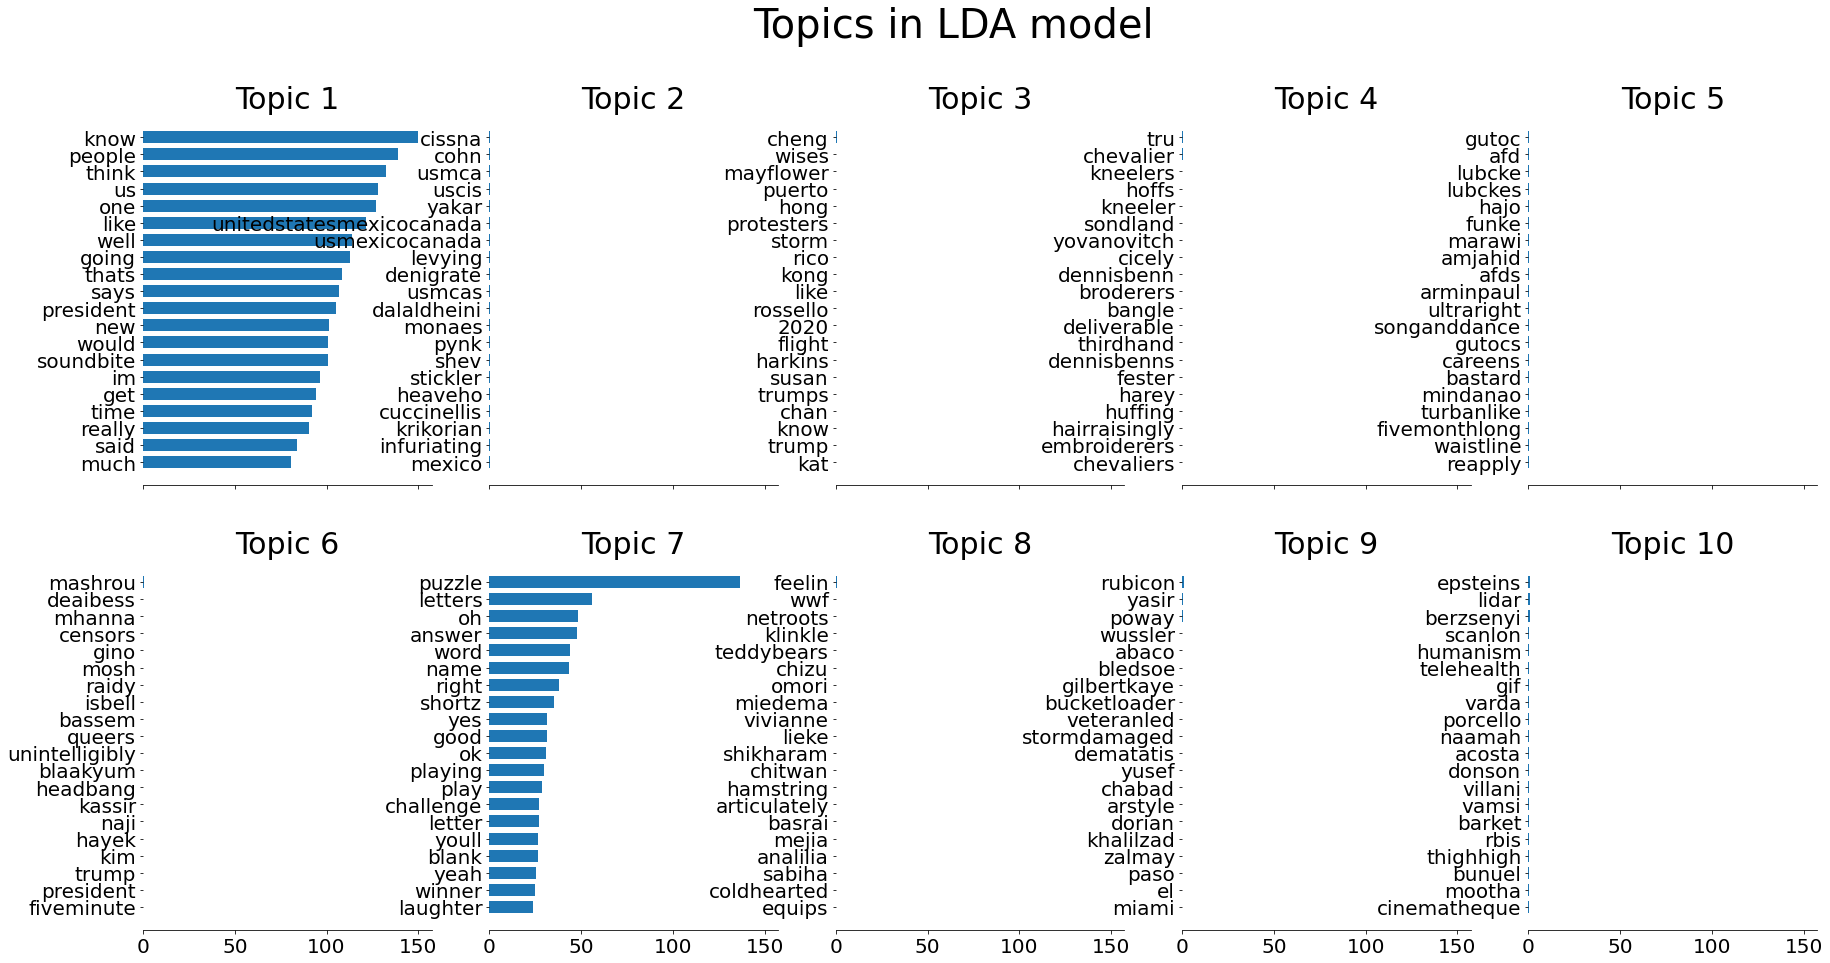

In [72]:
tf_feature_names = tfidf_vec_sunday.get_feature_names_out()
plot_top_words(lda_model_sunday, tf_feature_names, 20, "Topics in LDA model")

Our best model may not have been the best for "Weekend Edition Sunday." In other words, our model may have overfitted to "Talk of the Nation." The persistent problem of 'pseudo stop words' (e.g. "know," "think" etc) shows up here as well.

We can try increasing the number of clusters from 20 to 30.

In [82]:
lda_model_sunday_2 = LatentDirichletAllocation(n_components=30, max_iter=10,learning_method="online",random_state=100)

In [83]:
lda_output_sunday2 = lda_model_sunday_2.fit_transform(tfidf_sunday)

IndexError: ignored

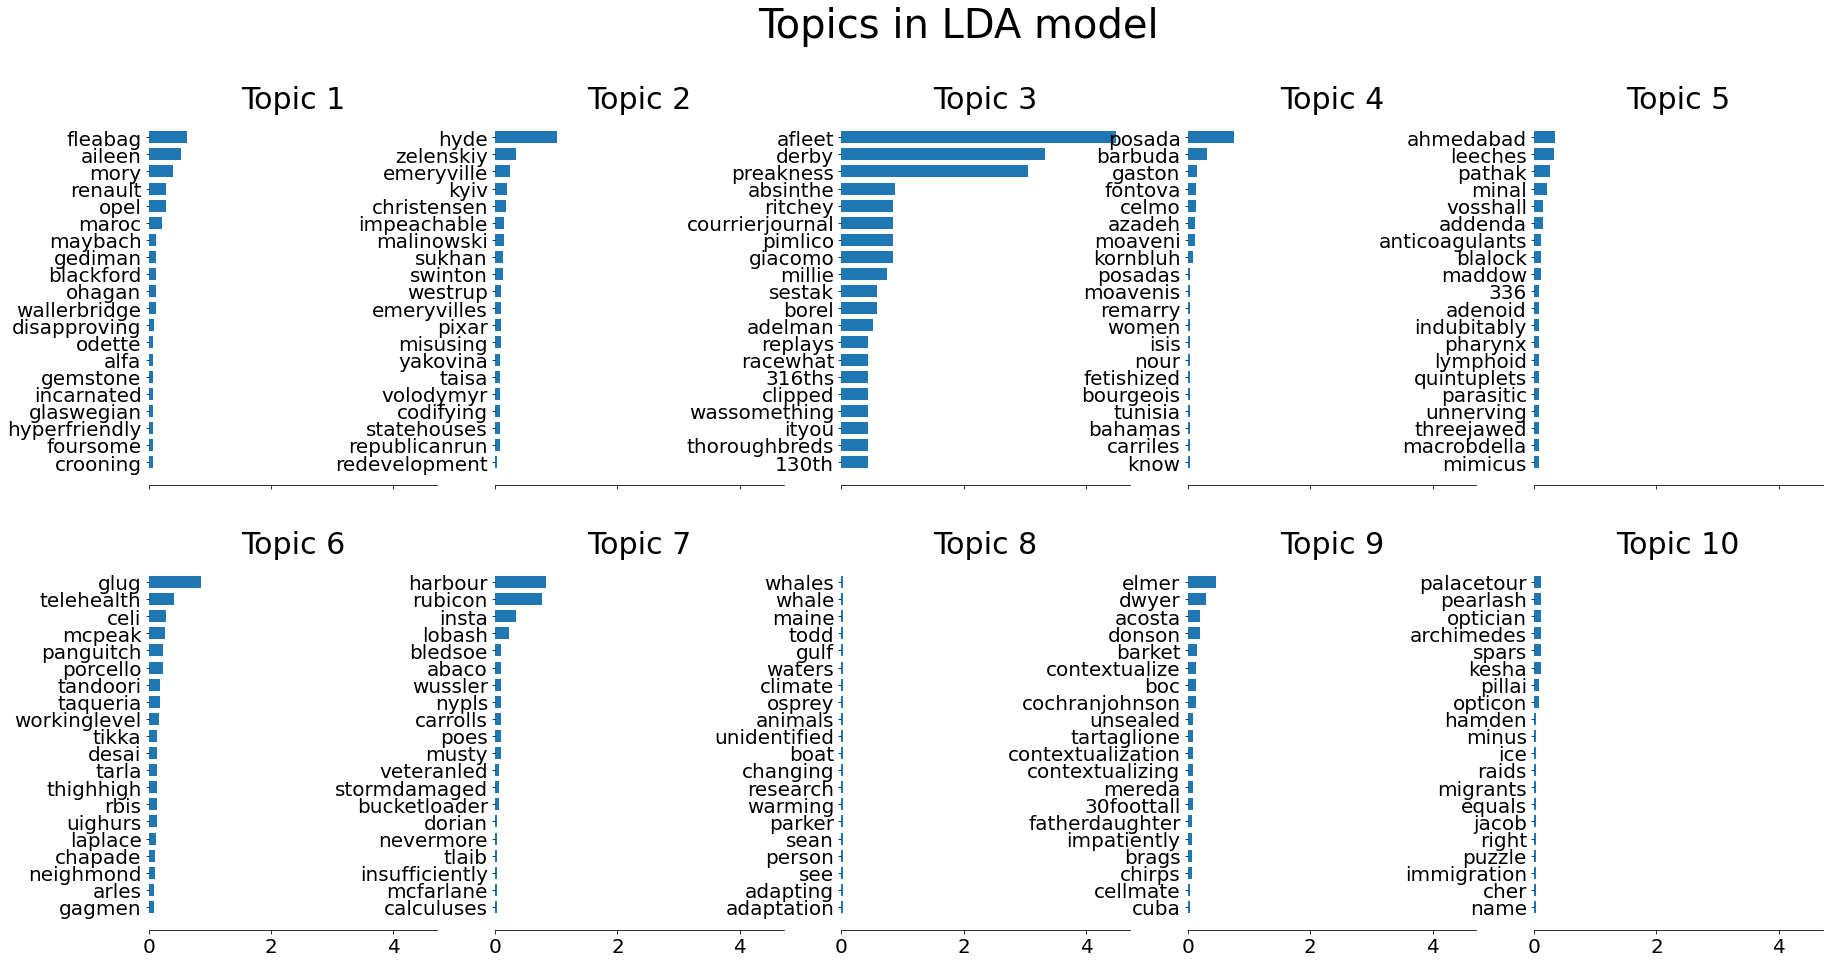

In [84]:
tf_feature_names = tfidf_vec_sunday.get_feature_names_out()
plot_top_words(lda_model_sunday_2, tf_feature_names, 20, "Topics in LDA model")

Increasing the number of clusters improved the situation. For example, Topic 2 seems to focus on Ukraine and President Zelenskiy, but also has mixed with other topics as well.